---
title: Converged Beam Blochwaves
authors: [gvarnavides]
date: 2025-01-27
---

In [1]:
import py4DSTEM
import abtem
import ase

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from matplotlib import cm
import matplotlib.colors

## Blochwaves with py4DSTEM

In [2]:
Si3N4_crystal = ase.Atoms(
    "Si6N8",
    scaled_positions=[
        (0.82495, 0.59387, 0.75),
        (0.23108, 0.82495, 0.25),
        (0.59387, 0.76892, 0.25),
        (0.40614, 0.23108, 0.75),
        (0.76892, 0.17505, 0.75),
        (0.17505, 0.40613, 0.25),
        
        (0.66667, 0.33334, 0.75),
        (0.33334, 0.66667, 0.25),
        (0.66986, 0.70066, 0.75),
        (0.96920, 0.66986, 0.25),
        (0.70066, 0.03081, 0.25),
        (0.29934, 0.96919, 0.75),
        (0.33015, 0.29934, 0.25),
        (0.03081, 0.33014, 0.75),
    ],
    cell=[7.6045, 7.6045, 2.9052, 90, 90, 120],
    pbc=True
)
Si3N4_orthorhombic = abtem.orthogonalize_cell(Si3N4_crystal)
cell_thickness = Si3N4_orthorhombic.cell[2,2]
cell_thicknesses = np.arange(cell_thickness*50,cell_thickness*400,cell_thickness*100)

In [3]:
g_max = 4
sg_max = 0.1
thermal_sigma = 0.1
energy = 300e3

In [4]:
Si3N4_py4d = py4DSTEM.process.diffraction.Crystal(
    positions=Si3N4_orthorhombic.get_scaled_positions(),
    numbers=Si3N4_orthorhombic.numbers,
    cell=Si3N4_orthorhombic.cell.array,
)

# Si3N4_py4d.calculate_structure_factors(
#     k_max=g_max,
#     tol_structure_factor=-1,
# )

Si3N4_py4d.calculate_dynamical_structure_factors(
    energy,
    "Lobato",
    k_max=g_max,
    thermal_sigma=thermal_sigma,
    tol_structure_factor=-1,
)

ZA = np.array([0,0,1])

beams = Si3N4_py4d.generate_diffraction_pattern(
    zone_axis_lattice=ZA,
    sigma_excitation_error=sg_max,
)

## CBED Patterns

In [5]:
cbed_alpha_mrad = 1
cbed_reciprocal_pixelsize = 0.01

In [14]:
cbeds = Si3N4_py4d.generate_CBED(
    beams=beams,
    thickness=cell_thicknesses,
    alpha_mrad=cbed_alpha_mrad,
    pixel_size_inv_A=cbed_reciprocal_pixelsize,
    DP_size_inv_A=cbed_reciprocal_pixelsize*96,
    zone_axis_lattice=ZA,
)

100%|███████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.97it/s]


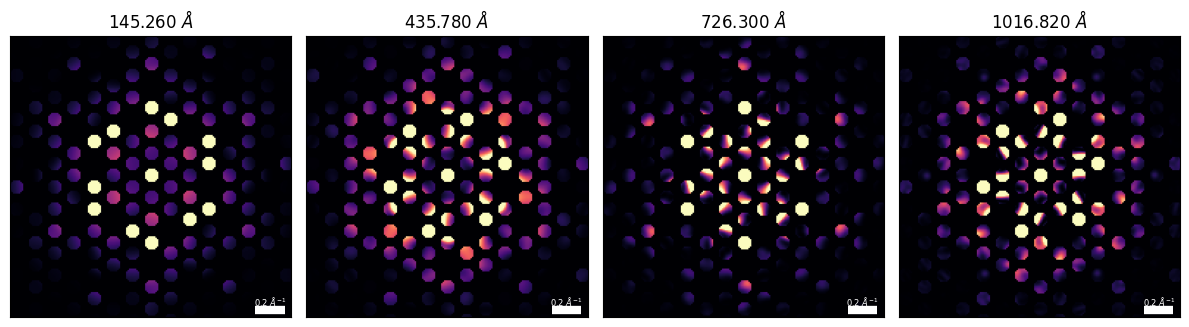

In [15]:
#| label: app:blochwave_cbed
cbeds_array = np.array(cbeds).swapaxes(-1,-2)
_, vmin, vmax = py4DSTEM.visualize.return_scaled_histogram_ordering(cbeds_array[-1],vmax=0.975)

fig, axs = plt.subplots(1,4,figsize=(12,4))

py4DSTEM.show(
    list(cbeds_array),
    cmap='magma',
    ticks=False,
    vmin=vmin,vmax=vmax,intensity_range='absolute',
    figax=(fig,axs),
    scalebar={'position':'ur'},
    origin='lower',
    pixelsize=cbed_reciprocal_pixelsize,
    pixelunits=r"$\AA^{-1}$"
)

for ax, thickness in zip(axs.ravel(),cell_thicknesses):
    ax.texts[0].set_va('bottom')
    ax.set_title(rf"{thickness:.3f} $\AA$")
    
fig.tight_layout()

In [16]:
pacbed_alpha_mrad = 5
pacbed_reciprocal_pixelsize = 0.02

In [17]:
pacbeds = Si3N4_py4d.generate_CBED(
    beams=beams,
    thickness=cell_thicknesses,
    alpha_mrad=pacbed_alpha_mrad,
    pixel_size_inv_A=pacbed_reciprocal_pixelsize,
    DP_size_inv_A=pacbed_reciprocal_pixelsize*48,
    zone_axis_lattice=ZA,
)

100%|█████████████████████████████████████████████████████████████| 517/517 [02:53<00:00,  2.98it/s]


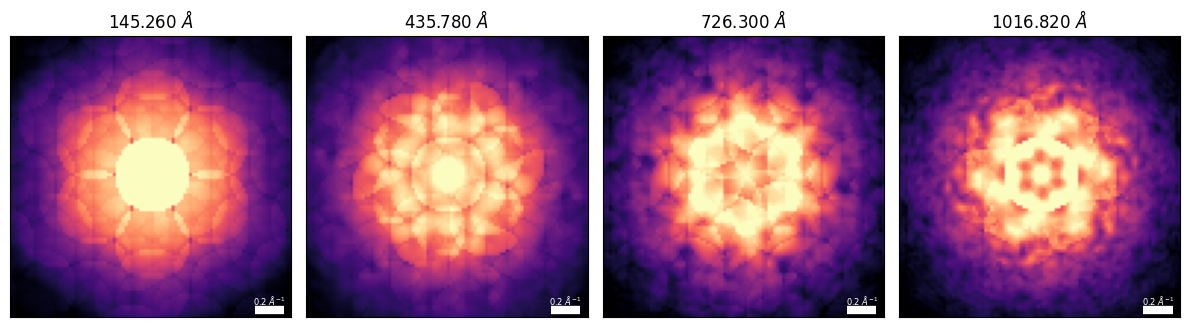

In [22]:
#| label: app:blochwave_pacbed

pacbeds_array = np.array(pacbeds).swapaxes(-1,-2)**0.25
_, vmin, vmax = py4DSTEM.visualize.return_scaled_histogram_ordering(pacbeds_array[-1],vmax=0.95)

fig, axs = plt.subplots(1,4,figsize=(12,4))

py4DSTEM.show(
    list(pacbeds_array),
    cmap='magma',
    ticks=False,
    vmin=vmin,vmax=vmax,intensity_range='absolute',
    figax=(fig,axs),
    scalebar={'position':'ur'},
    origin='lower',
    pixelsize=pacbed_reciprocal_pixelsize,
    pixelunits=r"$\AA^{-1}$"
)

for ax, thickness in zip(axs.ravel(),cell_thicknesses):
    ax.texts[0].set_va('bottom')
    ax.set_title(rf"{thickness:.3f} $\AA$")
    
fig.tight_layout()

## Tilted Diffraction Comparison

In [24]:
x_angles = np.linspace(0,120e-3,4)
y_angles = np.linspace(120e-3,0,4)
xy_angles = np.dstack(np.meshgrid(x_angles,y_angles,indexing='ij')).reshape((-1,2))

orientation_matrices = Rotation.from_euler('xy',xy_angles).as_matrix()
rotated_ZAs = Rotation.from_matrix(orientation_matrices).apply(ZA)

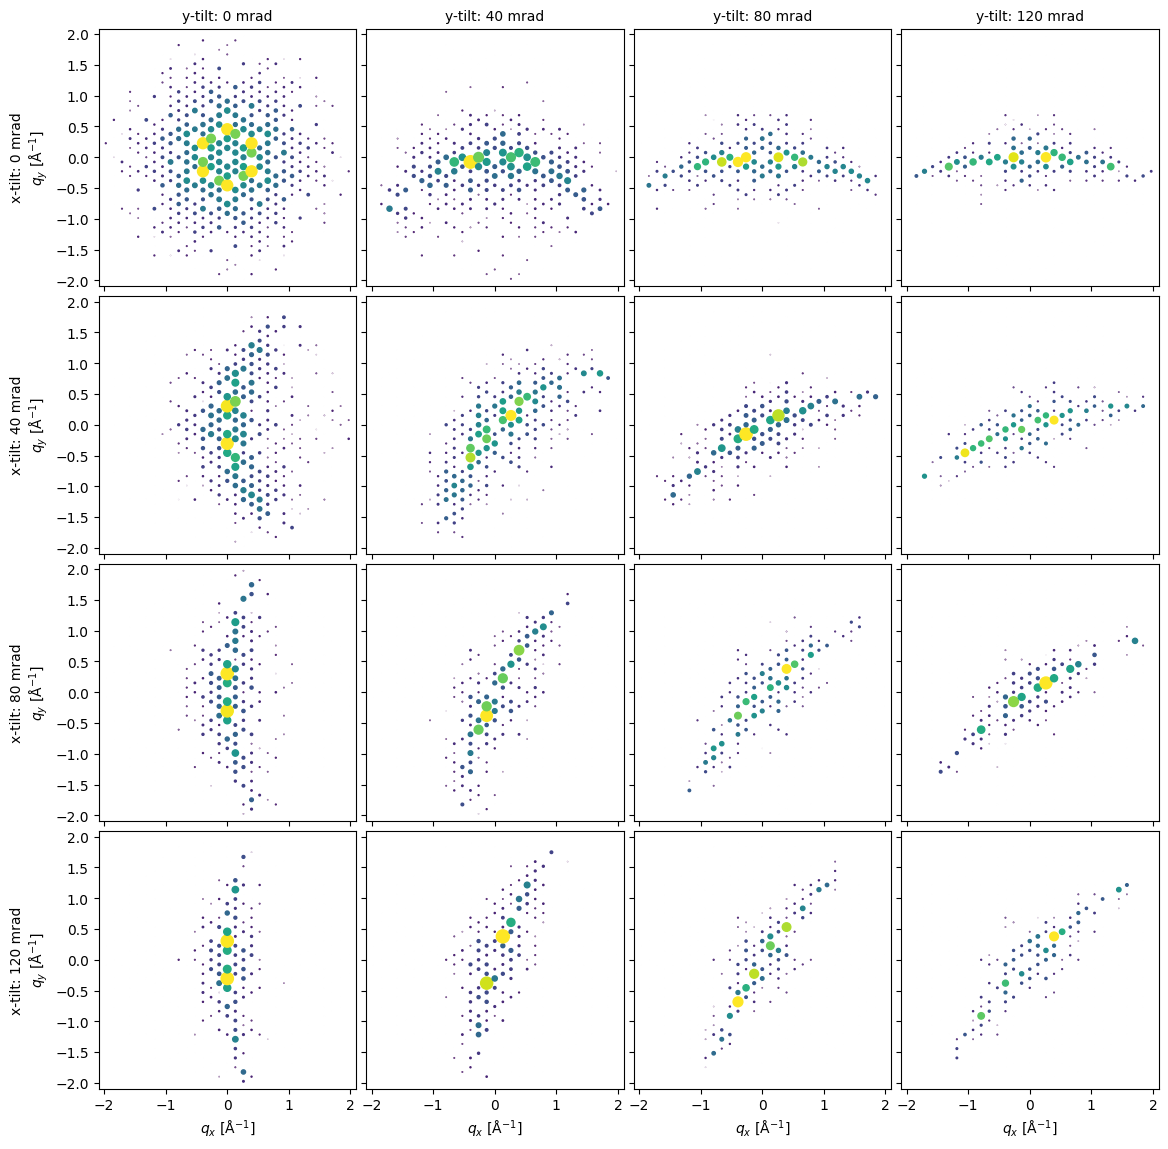

In [26]:
#| label: app:blochwave_precession_py4d

fig = plt.figure(figsize=(12,12))
axes = abtem.visualize.axes_grid.AxesGrid(
    fig=fig,
    ncols=4,
    nrows=4,
)._axes


y_indices = np.tile(np.arange(4),4)
x_indices = np.repeat(np.arange(4),4)

for za, ax, x_ind, y_ind in zip(rotated_ZAs,axes.ravel(),x_indices, y_indices):
    dynamical_beams = Si3N4_py4d.generate_dynamical_diffraction_pattern(
        beams=beams,
        thickness=cell_thicknesses[0],
        zone_axis_cartesian=za,
    )
    
    # block direct beam and clip low intensities
    direct_index = np.where(
        (dynamical_beams['h'] == 0) & 
        (dynamical_beams['k'] == 0) & 
        (dynamical_beams['l'] == 0)
    )[0][0]

    threshold = 2.5e-3
    clipped_intensity = dynamical_beams['intensity'].copy()**0.5
    clipped_intensity[direct_index] = threshold

    clipped_intensity = clipped_intensity.clip(threshold) - threshold
    dynamical_beams.data['intensity'] = clipped_intensity
    
    py4DSTEM.process.diffraction.plot_diffraction_pattern(
        dynamical_beams,
        add_labels=False,
        scale_markers=250,
        input_fig_handle=(fig,(ax,))
    )
    ax.xaxis.tick_bottom()
    ax.invert_yaxis()

    # transpose x and y to match abtem
    col = ax.collections[0]
    col.set_offsets(np.flip(col.get_offsets(),axis=1))

    # set colors 
    norm = matplotlib.colors.Normalize()
    colors = cm.viridis(norm(clipped_intensity**0.5))
    col.set_color(colors)

    if x_ind == 0:
        if y_ind == 0:
            x_label = ax.get_xlabel()
            y_label = ax.get_ylabel()
        ax.set_ylabel(f"x-tilt: {x_angles[3-y_ind]*1e3:.0f} mrad\n"+x_label)
    if y_ind == 3:
        ax.set_title(f"y-tilt: {y_angles[3-x_ind]*1e3:.0f} mrad",fontsize=10)
    if y_ind == 0:
        ax.set_xlabel(y_label)